In [ ]:
!pip install gym==0.22

In [ ]:
!pip install numpy==1.23

# **Imports**

In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import os
import base64
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

# **Environment**

In [ ]:
# create Taxi environment
env = gym.make('Taxi-v3')
seed=0
env.reset(seed=seed)

state_space = env.observation_space.n
print("There are ", state_space, " possible states")
action_space = env.action_space.n
print("There are ", action_space, " possible actions")
threshold_reward = env.spec.reward_threshold
print("Threshold reward: ", threshold_reward)

print("----")

state = env.reset()
print("State: ", state)
# Primitive Actions
action = ["up", "right", "down", "left", "pickUp", "dropOff"]

# Example Transitions
rnd_action = random.randint(0, 5)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

taxi_row, taxi_col, passenger_loc, destination = env.decode(state)
print("Taxi Row:", taxi_row)
print("Taxi Column:", taxi_col)
print("Passenger Location:", passenger_loc)
print("Destination:", destination)
env.render()

There are  500  possible states
There are  6  possible actions
Threshold reward:  8
----
State:  131
Action taken: left
Transition probability: {'prob': 1.0}
Next state: 111
Reward recieved: -1
Terminal state: False
Taxi Row: 1
Taxi Column: 1
Passenger Location: 2
Destination: 3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


# **Epdilon Greedy**

In [ ]:
def egreedy_policy(q_values, state, epsilon):
  if q_values[state].any() and random.random() > epsilon:
    return np.argmax(q_values[state])
  choice = random.randint(0, q_values.shape[-1] - 1)
  return choice

# **Option Policies**

In [ ]:
num_options = 4
LOCATIONS = {0:[0,0], 1:[0,4], 2:[4,0], 3:[4,3]}

def option_policy(env, state, q_values, action, epsilon=0.1, locations=LOCATIONS):
    option_done = False
    taxi_x, taxi_y, passenger, dropoff = env.decode(state)

    if (taxi_x == locations[action][0] and taxi_y == locations[action][1]):
        option_done = True
        if passenger == action:
            option_action = 4
        elif dropoff == action:
            option_action = 5
        else:
            option_action = 1 if (action in [0, 1]) else 0
    else:
        option_action = egreedy_policy(q_values[action], 5 * taxi_x + taxi_y, epsilon=epsilon)

    return [option_action, option_done]

In [ ]:
CENTRAL_AREA = [(2, 2)]
EDGES = [(x, y) for x in range(5) for y in range(5) if x == 0 or x == 4 or y == 0 or y == 4]
BORDERS = [(0, y) for y in range(1, 4)] + [(4, y) for y in range(1, 4)] + [(x, 0) for x in range(1, 4)] + [(x, 4) for x in range(1, 4)]

def alternate_option_policy(env, state, q_values, option, epsilon=0.1):
    taxi_x, taxi_y, passenger, dropoff = env.decode(state)

    if option == 0 and (taxi_x, taxi_y) in CENTRAL_AREA:
        option_done = True
    elif option == 1 and (taxi_x, taxi_y) in EDGES:
        option_done = True
    elif option == 2 and (taxi_x, taxi_y) in BORDERS:
        option_done = True
    elif option == 3:
        option_done = True
    else:
        option_done = False

    if not option_done:
        option_action = egreedy_policy(q_values[option], 5 * taxi_x + taxi_y, epsilon=epsilon)
    else:
        if passenger == 4:
            option_action = 5
        elif (taxi_x, taxi_y) == CENTRAL_AREA[0]:
            option_action = random.choice([0, 1, 2, 3])
        else:
            option_action = 4

    return [option_action, option_done]


# **SMDP Q Learning**

In [ ]:
RENDER = False
T = 1
num_rows = 5
num_cols = 5
num_passengers = 5
num_dropoffs = 4
state_space = env.observation_space.n
action_space = env.action_space.n
num_episodes = 10000

In [ ]:
def SMDP_learning(Option, gamma=0.9, learning_rate=0.1, epsilon_decay=0.99, seed=0, RENDER=False):
    main_epsilon = 0.1
    min_epsilon = 0.01
    count = 0
    q_values_SMDP = np.zeros((num_passengers * num_dropoffs, num_options))
    updates_SMDP = np.zeros((num_passengers * num_dropoffs, num_options))
    option_Q_values = {i: np.zeros((state_space // 20, action_space - 2)) for i in range(num_options)}
    option_eps = {i: 0.01 for i in range(num_options)}
    smdp_rewards = []
    for i in tqdm(range(num_episodes)):
        state = env.reset()
        env.reset(seed=seed)
        done = False
        total_reward = 0

        while not done:
            taxi_x, taxi_y, passenger, dropoff = env.decode(state)
            sub_state = num_dropoffs * passenger + dropoff
            option = egreedy_policy(q_values_SMDP, sub_state, epsilon=main_epsilon)
            main_epsilon = max(min_epsilon, epsilon_decay * main_epsilon)
            reward_sum = 0
            option_done = False
            num_moves = 0
            prev_state = state

            taxi_x, taxi_y, passenger, dropoff = env.decode(state)
            option_done = False

            while not option_done and not done:
              option_action, option_done = Option(env, state, option_Q_values, option, option_eps[option])

              taxi_x, taxi_y, passenger, dropoff = env.decode(state)

              next_state, reward, done,_ = env.step(option_action)
              taxi_x_next, taxi_y_next, passenger, dropoff = env.decode(next_state)
              reward_sum = gamma * reward_sum + reward
              num_moves += 1
              total_reward += reward
              if RENDER:
                  clear_output(wait=True)
                  print(env.render())
                  time.sleep(T)

              option_eps[option] = max(min_epsilon, epsilon_decay * option_eps[option])

              reward_surrogate = reward if not option_done else 20
              if option_action < 4:
                  option_Q_values[option][5 * taxi_x + taxi_y, option_action] += learning_rate * (
                              reward_surrogate + gamma * np.max(option_Q_values[option][5 * taxi_x_next + taxi_y_next, :]) -
                              option_Q_values[option][5 * taxi_x + taxi_y, option_action])
              state = next_state


            _, _, prev_passenger, prev_dropoff = env.decode(prev_state)
            prev_sub_state = num_dropoffs * prev_passenger + prev_dropoff

            _, _, next_passenger, next_dropoff = env.decode(state)
            sub_state = num_dropoffs * next_passenger + next_dropoff

            q_values_SMDP[prev_sub_state, option] += learning_rate * (
                        reward_sum + (gamma ** num_moves) * np.max(q_values_SMDP[sub_state, :]) -
                        q_values_SMDP[prev_sub_state, option])
            updates_SMDP[prev_sub_state, option] += 1
        smdp_rewards.append(total_reward)
        taxi_x, taxi_y, passenger, dropoff = env.decode(state)
        if passenger == dropoff:
            count += 1
    return np.sum(smdp_rewards)/num_episodes, q_values_SMDP, updates_SMDP,option_Q_values, smdp_rewards, count

# **SMDP Evaluation**

In [ ]:
smdp_rewards_collection = []
q_values_SMDP_collection = []
option_Q_values_collection = []
counts = 0

for seed in range(5):
    smdp_reward, q_values_SMDP, updates_SMDP, option_Q_values, smdp_rewards, count = SMDP_learning(option_policy, seed=seed, RENDER=False)
    smdp_rewards_collection.append(smdp_rewards)
    q_values_SMDP_collection.append(q_values_SMDP)
    option_Q_values_collection.append(option_Q_values)
    counts += count

100%|██████████| 10000/10000 [00:09<00:00, 1055.16it/s]


In [ ]:
# alternate_option_policy
smdp_rewards_collection_alternative = []
for seed in range(5):
    smdp_reward, q_values_SMDP, updates_SMDP, option_Q_values, smdp_rewards, count = SMDP_learning(alternate_option_policy, seed=seed, RENDER=False)
    smdp_rewards_collection_alternative.append(smdp_rewards)

100%|██████████| 10000/10000 [02:38<00:00, 63.10it/s]


# **SMDP Visualization**

## **SMDP Reward Plot**

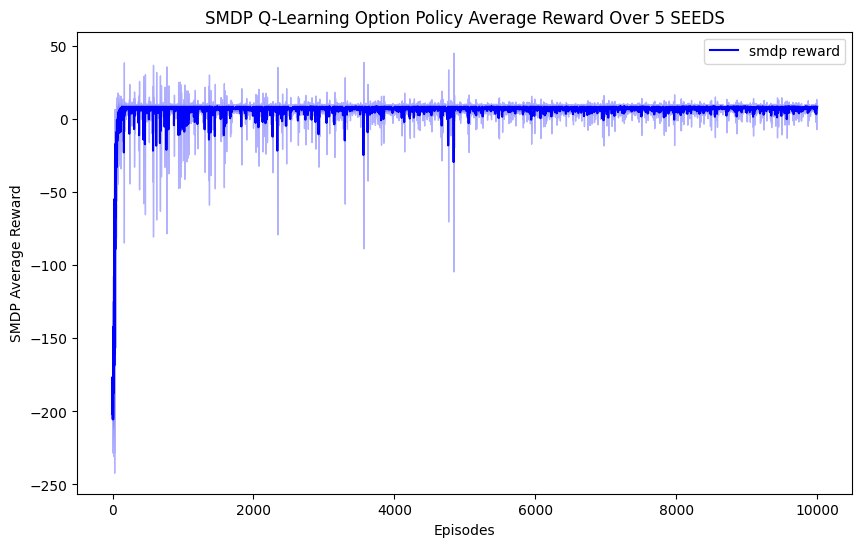

In [ ]:
smdp_mean = np.mean(smdp_rewards_collection, axis=0)
smdp_std = np.std(smdp_rewards_collection, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(smdp_mean, label=f'smdp reward', color='blue')
plt.fill_between(range(len(smdp_mean)),
                smdp_mean - smdp_std,
                smdp_mean + smdp_std,
                alpha=0.3, color='blue')
plt.title(f'SMDP Q-Learning Option Policy Average Reward Over 5 SEEDS')
plt.xlabel('Episodes')
plt.ylabel('SMDP Average Reward')
plt.legend()
plt.show()

In [ ]:
def plot_type1_and_type2(option_policy_score, alternative_option_policy_score, algo_name):

    type1_mean = np.mean(option_policy_score, axis=0)
    type1_std = np.std(option_policy_score, axis=0)

    # Calculate mean and standard deviation for Type-2 scores
    type2_mean = np.mean(alternative_option_policy_score, axis=0)
    type2_std = np.std(alternative_option_policy_score, axis=0)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot Type-1 scores
    plt.plot(type1_mean, label=f'option policy {algo_name}', color='blue')
    plt.fill_between(range(len(type1_mean)),
                    type1_mean - type1_std,
                    type1_mean + type1_std,
                    alpha=0.3, color='blue')

    # Plot Type-2 scores
    plt.plot(type2_mean, label=f'alternative option {algo_name}', color='red')
    plt.fill_between(range(len(type2_mean)),
                    type2_mean - type2_std,
                    type2_mean + type2_std,
                    alpha=0.3, color='red')

    # Plot labels and legend
    plt.title(f'Comparison of option and alternative option {algo_name}')
    plt.xlabel('Episodes')
    plt.ylabel('Average Score')
    plt.legend()

    # Show plot
    plt.show()

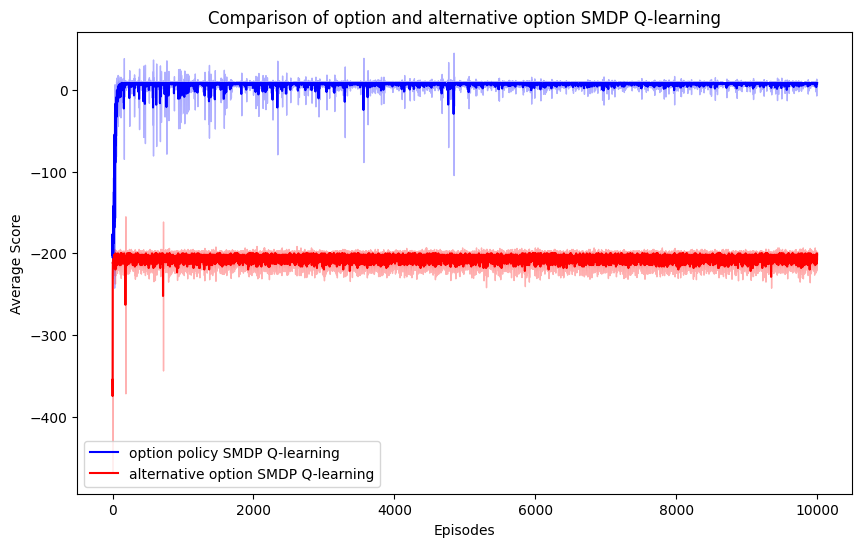

In [ ]:
plot_type1_and_type2(smdp_rewards_collection, smdp_rewards_collection_alternative, 'SMDP Q-learning')

## **SMDP Q-Table**

In [ ]:
if q_values_SMDP_collection:
    avg_q_values_SMDP = np.mean(q_values_SMDP_collection, axis=0)

if option_Q_values_collection:
    avg_option_Q_values = {i: np.zeros((state_space // 20, action_space - 2)) for i in range(num_options)}
    for i in range(num_options):
        option_arrays = [option_Q_values[i] for option_Q_values in option_Q_values_collection if option_Q_values]
        if option_arrays:
            avg_option_Q_values[i] = np.mean(option_arrays, axis=0)

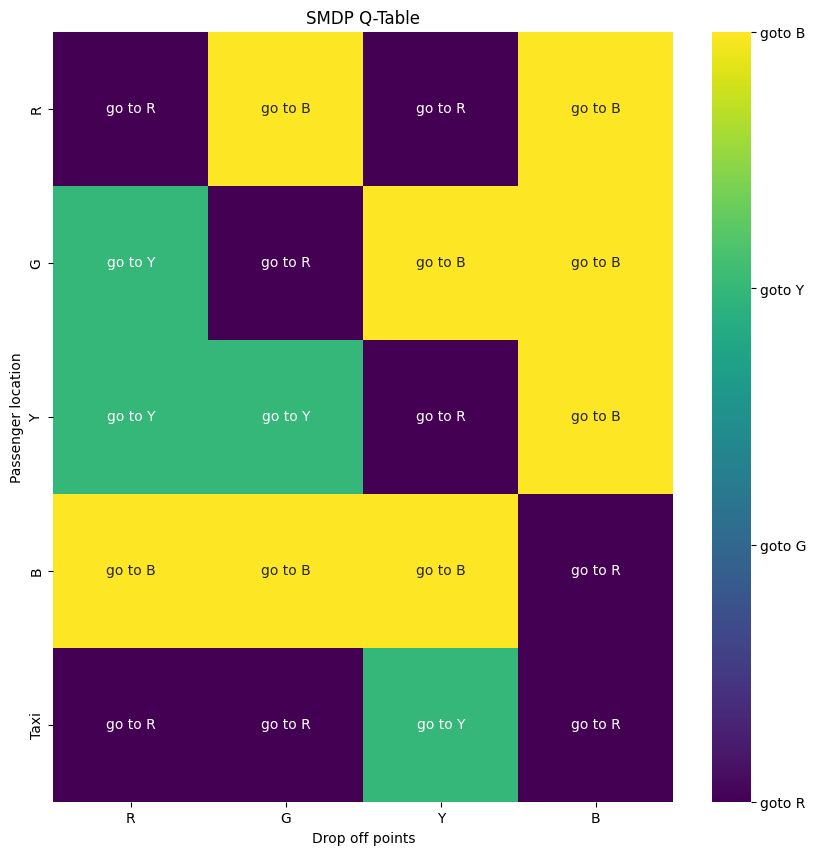

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate Qmax_SMDP
Qmax_SMDP = np.argmax(avg_q_values_SMDP, axis=1).reshape(5, 4)
labels = {0: 'go to R', 1: 'go to G', 2: 'go to Y', 3: 'go to B'}
annot_text = np.vectorize(lambda x: f'{labels[x]}')(Qmax_SMDP)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(Qmax_SMDP, annot=annot_text, fmt='', xticklabels=["R", "G", "Y", "B"], yticklabels=['R', 'G', 'Y', 'B', 'Taxi'], cmap='viridis')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['goto R', 'goto G', 'goto Y', 'goto B'])
plt.xlabel('Drop off points')
plt.ylabel('Passenger location')
plt.title('SMDP Q-Table')
plt.show()

## **Options Policy Learned by SMDP**

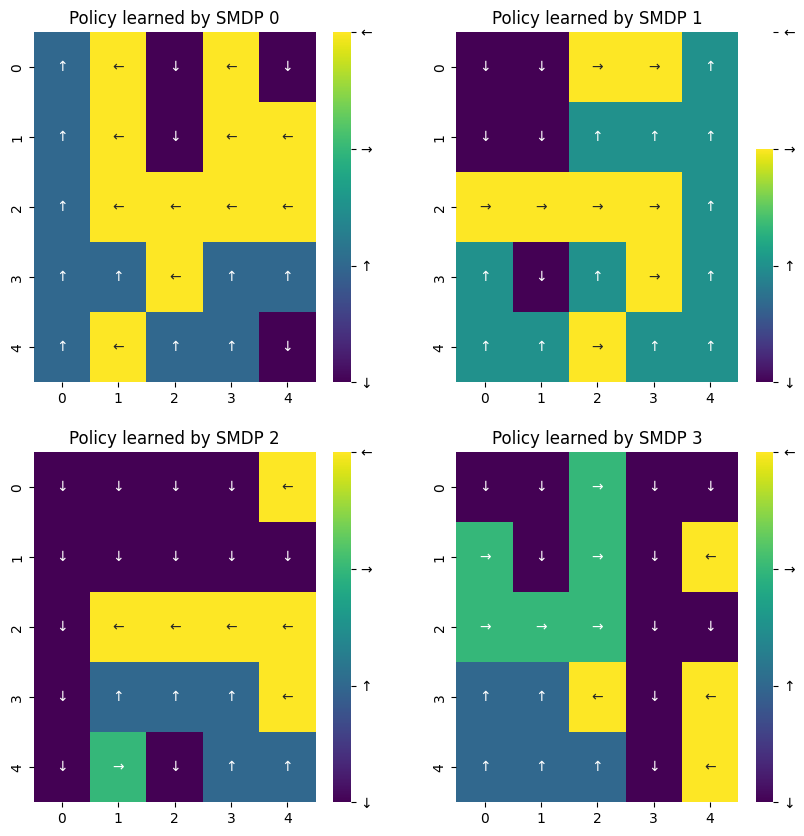

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
arrows = {0: '↓', 1: '↑', 2: '→', 3: '←'}
for row in range(2):
    for col in range(2):
        policy = np.argmax(avg_option_Q_values[2*row+col], axis=1).reshape(5, 5)
        annot_text = np.vectorize(arrows.get)(policy)
        ax = sns.heatmap(policy, ax=axes[row, col], annot=annot_text, fmt='', cmap='viridis')
        axes[row, col].set_title("Policy learned by SMDP {}".format(row*2+col))
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([i for i in range(4)])
        c_bar.set_ticklabels(['↓', '↑', '→', '←'])
plt.show()

# **Intra-Option Q-Learning**

In [ ]:
RENDER = False
from IPython.display import clear_output
import time
num_passengers = 5
num_dropoffs = 4
state_space = env.observation_space.n
action_space = env.action_space.n
num_episodes = 10000
num_options = 4
LOCATIONS = {0:[0,0], 1:[0,4], 2:[4,0], 3:[4,3]}

def option_policy(env, state, q_values, action, epsilon=0.1, locations=LOCATIONS):
    option_done = False
    taxi_x, taxi_y, passenger, dropoff = env.decode(state)

    if (taxi_x == locations[action][0] and taxi_y == locations[action][1]):
        option_done = True
        if passenger == action:
            option_action = 4
        elif dropoff == action:
            option_action = 5
        else:
            option_action = 1 if (action in [0, 1]) else 0
    else:
        option_action = egreedy_policy(q_values[action], 5 * taxi_x + taxi_y, epsilon=epsilon)

    return [option_action, option_done]
T=1
gamma = 0.9
alpha = 0.1
q_values_IOQL = np.zeros((num_passengers*num_dropoffs,num_options))
updates_IOQL = np.zeros((num_passengers*num_dropoffs,num_options))

Qopt = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(num_options)}

def IOQL(option_policy1):
  eps = {i:0.01 for i in range(num_options)}

  eps_min = 0.01
  eps_decay = 0.99
  eps_main = 0.1

  count = 0
  episodes = 10000
  Q=[]
  U=[]
  Qo=[]
  Reward=[]

  for j in range(0,5):
    rewards=[]
    q_values_IOQL = np.zeros((num_passengers*num_dropoffs,num_options))
    updates_IOQL = np.zeros((num_passengers*num_dropoffs,num_options))
    Qopt = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(num_options)}
    for i in tqdm(range(episodes)):
        state = env.reset()
        done = False
        t=0
        while not done:
            _,_,passenger,dropoffs = env.decode(state)
            subState = num_dropoffs*passenger+dropoffs
            action = egreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
            eps_main = max(eps_min,eps_main*eps_decay)
            if RENDER:
              clear_output(wait=True)
              print(env.render())
              time.sleep(T)

            option = action
            optdone = False
            prev = state
            while not optdone and not done:
                optact,optdone = option_policy1(env,state,Qopt,option,eps[option])
                next_state, reward, done,_ = env.step(optact)

                t+=reward

                [taxi_x,taxi_y,prev_passenger, prev_dropoff]=  list(env.decode(state))
                prev_sub_state = num_dropoffs * prev_passenger + prev_dropoff
                [taxi_x1,taxi_y1,next_passenger, next_dropoff]=  list(env.decode(next_state))
                sub_state = num_dropoffs * next_passenger + next_dropoff

                eps[option] = max(eps_min,eps_decay*eps[option])
                reward_surr = reward
                if optdone:
                  reward_surr = 20
                if optact<4:
                  Qopt[option][5*taxi_x+taxi_y, optact] = Qopt[option][5*taxi_x+taxi_y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*taxi_x1+taxi_y1, :]) - Qopt[option][5*taxi_x+taxi_y, optact])


                for o in range(num_options):
                  optact_o,optdone_o = option_policy1(env,state,Qopt,o,eps[o])
                  if optact_o == optact:
                    eps[o] = max(eps_min,eps_decay*eps[o])
                    if optdone_o:
                      q_values_IOQL[prev_sub_state, o] += alpha*(reward + gamma*np.max(q_values_IOQL[sub_state, :]) - q_values_IOQL[prev_sub_state, o])
                    else:
                      q_values_IOQL[prev_sub_state, o] += alpha*(reward + gamma*q_values_IOQL[sub_state, o] - q_values_IOQL[prev_sub_state, o])

                    updates_IOQL[prev_sub_state, o] += 1
                state = next_state

        rewards.append(t)
        taxi_x,taxi_y,passenger,dropoffs = env.decode(state)

    Reward.append(rewards)
    Q.append(q_values_IOQL)
    U.append(updates_IOQL)
    Qo.append(Qopt)
  return Reward,Q,U,Qo



100%|██████████| 10000/10000 [00:17<00:00, 582.63it/s]


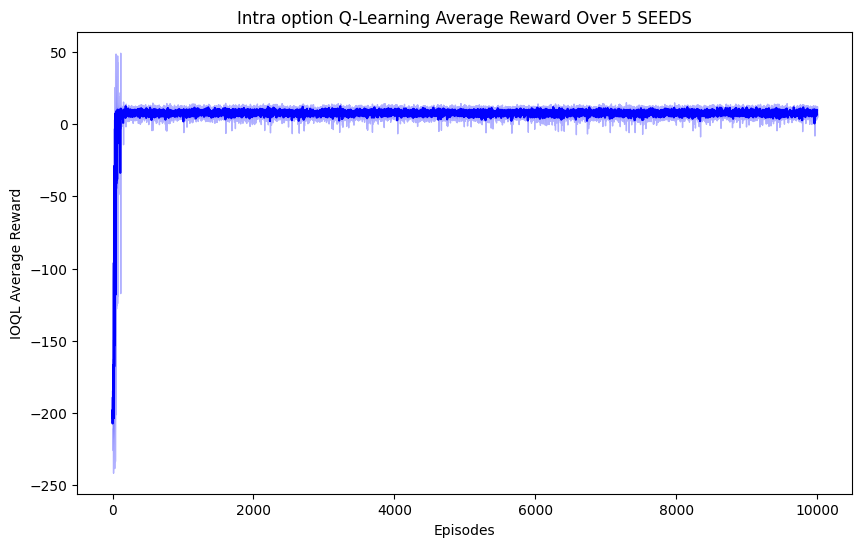

In [ ]:
Reward,Q,U,Qo = IOQL(option_policy)
ioql_mean = np.mean(Reward, axis=0)
ioql_std = np.std(Reward, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(ioql_mean, color='blue')
plt.fill_between(range(len(ioql_mean)),
                ioql_mean - ioql_std,
                ioql_mean + ioql_std,
                alpha=0.3, color='blue')
plt.title(f'Intra option Q-Learning Average Reward Over 5 SEEDS')
plt.xlabel('Episodes')
plt.ylabel('IOQL Average Reward')

plt.show()

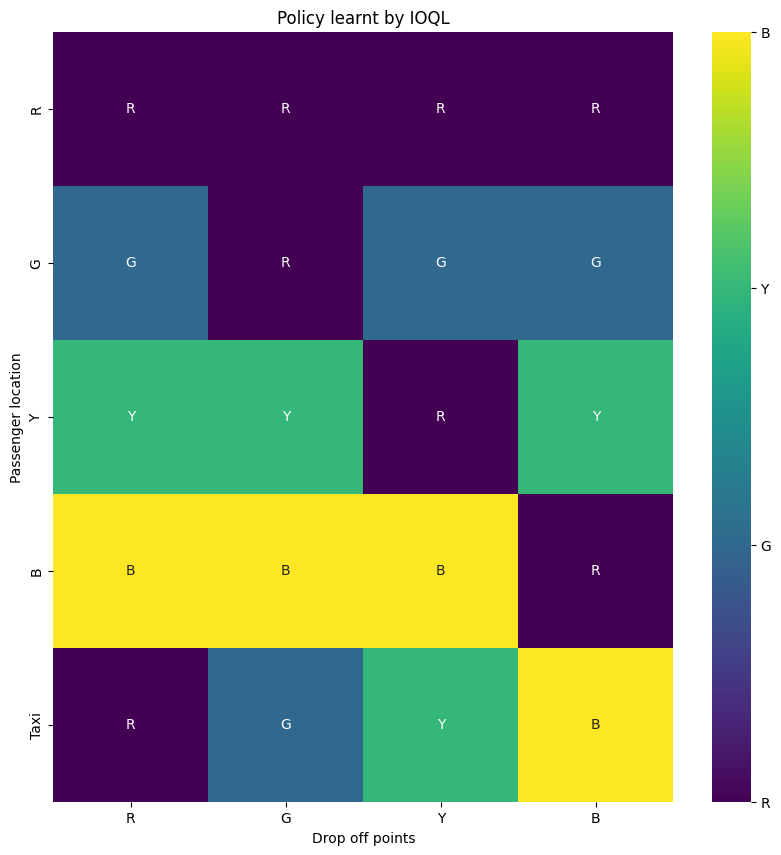

In [ ]:
q_values_IOQL=np.mean(Q,axis=0)

Qmax_IOQL = np.argmax(q_values_IOQL,axis = 1).reshape(5,4)
labels = {0: 'R', 1: 'G', 2: 'Y', 3: 'B'}
annot_text = np.vectorize(lambda x: f'{labels[x]}')(Qmax_IOQL)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(Qmax_IOQL, annot=annot_text, fmt='', xticklabels=["R", "G", "Y", "B"], yticklabels=['R', 'G', 'Y', 'B', 'Taxi'], cmap='viridis')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['R', 'G', 'Y', 'B'])
plt.xlabel('Drop off points')
plt.ylabel('Passenger location')
plt.title('Policy learnt by IOQL')
plt.show()

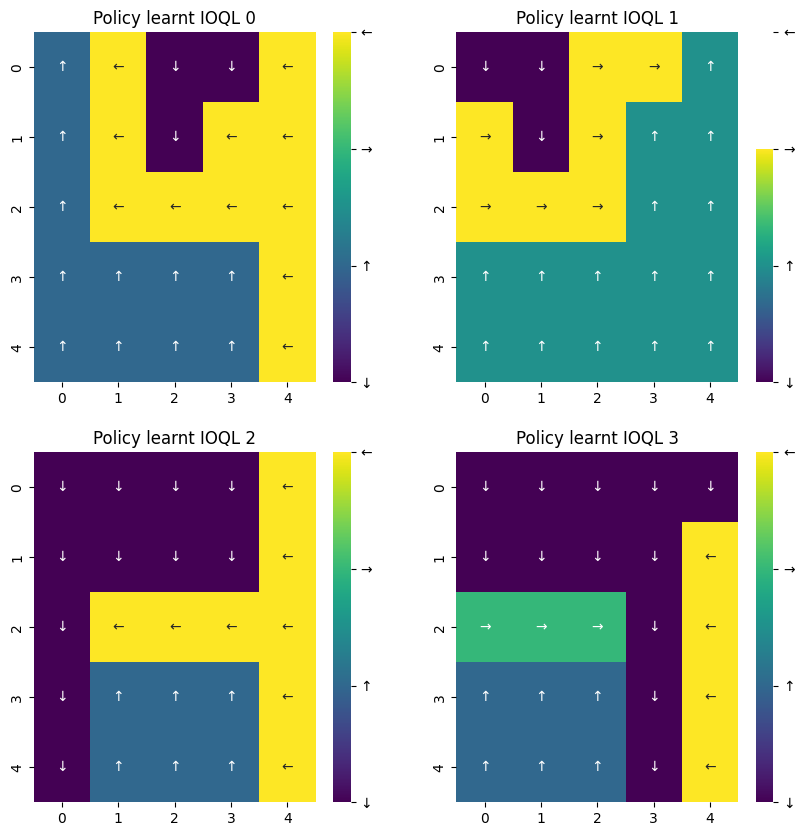

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Qo_values = [list(Qopt.values()) for Qopt in Qo]
average_Qopt = np.mean(Qo_values, axis=0)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
arrows = {0: '↓', 1: '↑', 2: '→', 3: '←'}
for row in range(2):
    for col in range(2):
        policy = np.argmax(average_Qopt[2*row+col], axis=1).reshape(5, 5)
        annot_text = np.vectorize(arrows.get)(policy)
        ax = sns.heatmap(policy, ax=axes[row, col], annot=annot_text, fmt='', cmap='viridis')
        axes[row, col].set_title("Policy learnt IOQL {}".format(row*2+col))
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([i for i in range(4)])
        c_bar.set_ticklabels(['↓', '↑', '→', '←'])
plt.show()


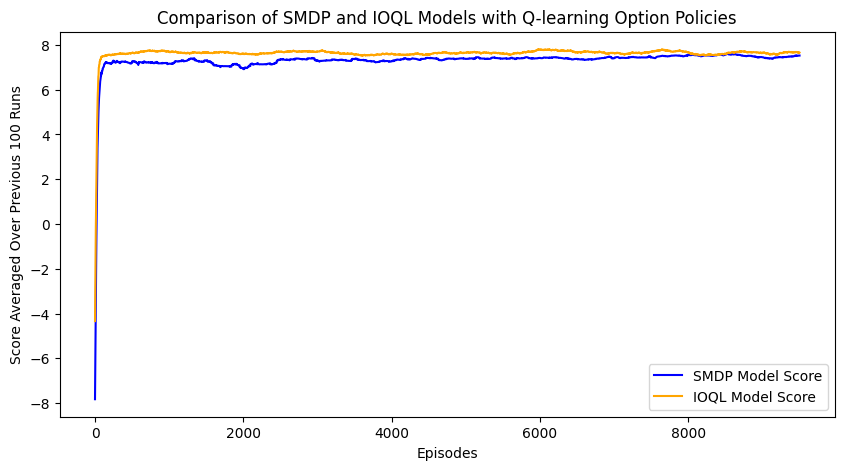

In [ ]:
plt.figure(figsize=(10, 5))
avg_rews_smdp = [np.average(smdp_mean[i:i+500]) for i in range(len(smdp_mean)-500)]
avg_rews_ioql = [np.average(ioql_mean[i:i+500]) for i in range(len(ioql_mean)-500)]
plt.plot(avg_rews_smdp, label='SMDP Model Score', color='blue')
plt.plot(avg_rews_ioql, label='IOQL Model Score', color='orange')
plt.xlabel('Episodes')
plt.ylabel('Score Averaged Over Previous 100 Runs')
plt.title('Comparison of SMDP and IOQL Models with Q-learning Option Policies')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


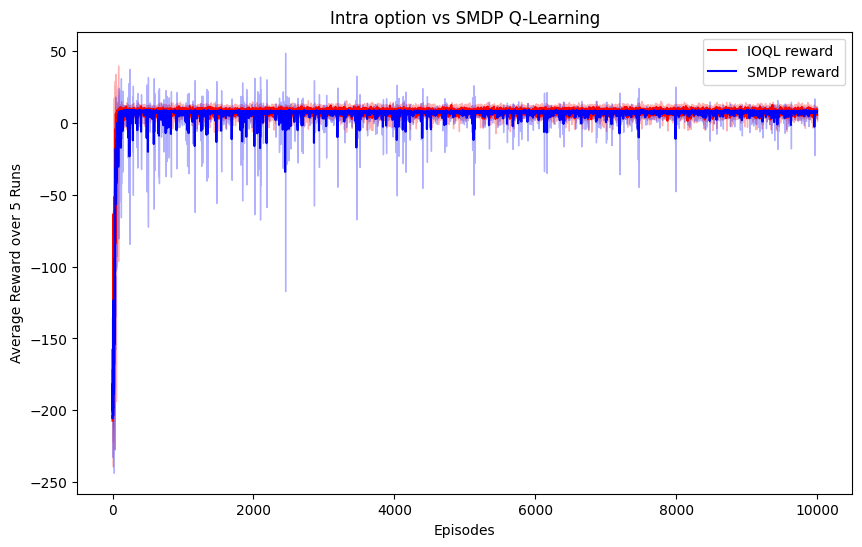

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(ioql_mean, label=f'IOQL reward', color='red')
plt.fill_between(range(len(ioql_mean)),
                ioql_mean - ioql_std,
                ioql_mean + ioql_std,
                alpha=0.3, color='red')
plt.plot(smdp_mean, label=f'SMDP reward', color='blue')
plt.fill_between(range(len(smdp_mean)),
                smdp_mean - smdp_std,
                smdp_mean + smdp_std,
                alpha=0.3, color='blue')
plt.title(f'Intra option vs SMDP Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Average Reward over 5 Runs')
plt.legend()
plt.show()

In [ ]:
Reward1,Q1,U1,Qo1 = IOQL(alternate_option_policy)
# Reward,Q,U,Qo = IOQL(option_policy)

100%|██████████| 10000/10000 [03:44<00:00, 44.63it/s]


In [ ]:
def plot_type1_and_type2(option_policy_score, alternative_option_policy_score, algo_name):

    type1_mean = np.mean(option_policy_score, axis=0)
    type1_std = np.std(option_policy_score, axis=0)

    # Calculate mean and standard deviation for Type-2 scores
    type2_mean = np.mean(alternative_option_policy_score, axis=0)
    type2_std = np.std(alternative_option_policy_score, axis=0)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot Type-1 scores
    plt.plot(type1_mean, label=f'Option policy {algo_name}', color='blue')
    plt.fill_between(range(len(type1_mean)),
                    type1_mean - type1_std,
                    type1_mean + type1_std,
                    alpha=0.3, color='blue')

    # Plot Type-2 scores
    plt.plot(type2_mean, label=f'Alternative option policy{algo_name}', color='red')
    plt.fill_between(range(len(type2_mean)),
                    type2_mean - type2_std,
                    type2_mean + type2_std,
                    alpha=0.3, color='red')

    # Plot labels and legend
    plt.title(f'Comparison of option and alternative option {algo_name}')
    plt.xlabel('Episodes')
    plt.ylabel('Average Score')
    plt.legend()

    # Show plot
    plt.show()

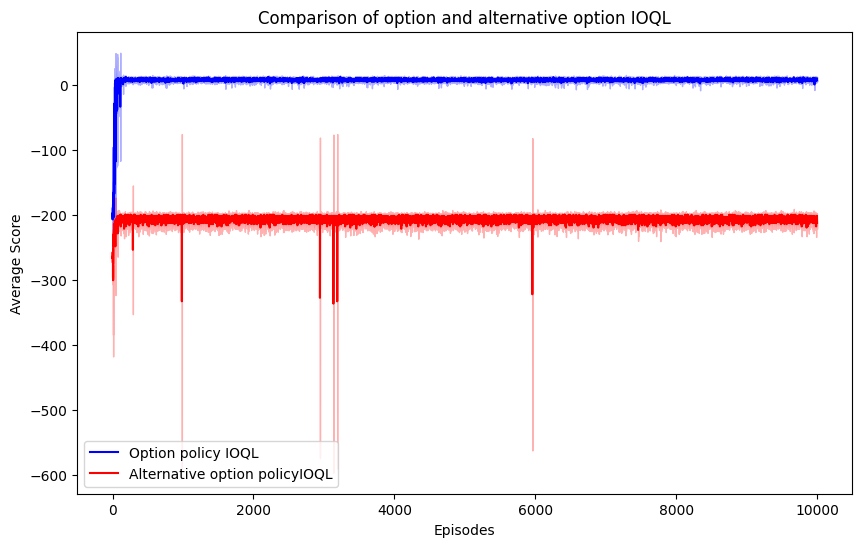

In [ ]:
plot_type1_and_type2(Reward, Reward1, "IOQL")